In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Define filepath
filepath = 'C:/Users/mengj/OneDrive - lamar.edu/LectureNote2023/MLforCivilEng/TeamProject2/WoodbineData_label2.xlsx'

df = pd.read_excel(filepath)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268 entries, 0 to 267
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      268 non-null    int64  
 1   StateWellN      268 non-null    int64  
 2   StateWel_1      268 non-null    int64  
 3   LatitudeDD      268 non-null    float64
 4   Dlat            268 non-null    int64  
 5   Mlat            268 non-null    int64  
 6   Slat            268 non-null    float64
 7   LongitudeD      268 non-null    float64
 8   Dlong           268 non-null    int64  
 9   Mlong           268 non-null    int64  
 10  Slong           268 non-null    float64
 11  TDS_mg/L        268 non-null    float64
 12  WellDepth       268 non-null    int64  
 13  SAR             268 non-null    float64
 14  Hardness_mg/L   268 non-null    float64
 15  Calcium_mg/L    268 non-null    float64
 16  Magnesium_mg/L  268 non-null    float64
 17  Sulfate_mg/L    268 non-null    flo

In [3]:
# set X, y
X = df[df.columns[11:26]]
X.drop(['Fluoride_mg/L','Texture_SSURGO'], axis=1, inplace=True)
print(X.columns)
y = df['label']

Index(['TDS_mg/L', 'WellDepth', 'SAR', 'Hardness_mg/L', 'Calcium_mg/L',
       'Magnesium_mg/L', 'Sulfate_mg/L', 'Chloride_mg/L', 'pH', 'Texture_Num',
       'Clay_SSURGO', 'SAR_SSURGO', 'EC_SSURGO'],
      dtype='object')


C:\Users\mengj\AppData\Local\Temp\ipykernel_14032\974104129.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(['Fluoride_mg/L','Texture_SSURGO'], axis=1, inplace=True)


In [4]:
# feature scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler((0,1))
X_scaled = scaler.fit_transform(X)
X_scaled

array([[0.07073126, 0.35879144, 0.21118793, ..., 0.75609756, 0.14285714,
        1.        ],
       [0.11776263, 0.43096937, 0.24245757, ..., 0.75609756, 0.14285714,
        1.        ],
       [0.0319273 , 0.42173731, 0.21280417, ..., 0.75609756, 0.14285714,
        1.        ],
       ...,
       [0.08571253, 0.07679396, 0.18622609, ..., 0.02439024, 0.        ,
        0.        ],
       [0.05771474, 0.05916911, 0.03133698, ..., 0.02439024, 0.        ,
        0.        ],
       [0.12334991, 0.07679396, 0.11432612, ..., 0.02439024, 0.        ,
        0.        ]])

In [5]:
# split training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [6]:
print(len(X_train), len(X_test))

187 81


## Gaussian naive Bayes classifier

In [7]:
from sklearn.naive_bayes import GaussianNB

# try default hyperparameters
model = GaussianNB()

In [8]:
model.get_params(deep=True)

{'priors': None, 'var_smoothing': 1e-09}

In sklearn API the model has four parameters: alpha, force_alpha, fit_prior, class_prior.
But when we set them there is an error said "force_alpha" parameter should not be put in this model.

In [9]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Evaluate the performance of the model

In [10]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve
)

In [11]:
# accuracy score
accur = accuracy_score(y_pred, y_test)
print(accur)

0.7654320987654321


In [12]:
f1 = f1_score(y_pred, y_test, average="weighted")
print(f1)

0.7492975944514533


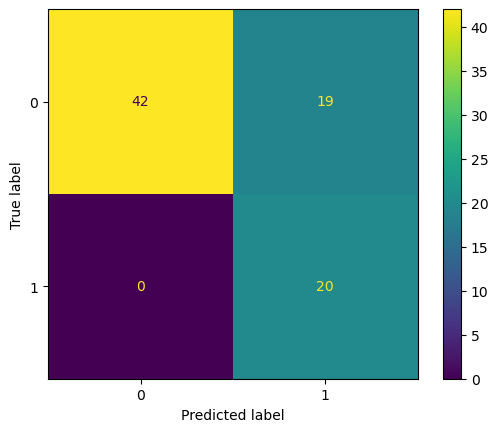

In [13]:
# The confusion matrix
labels = [0,1]
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot();

## Optimize NBC model with optuma

In [14]:
import optuna

In [15]:
# define objective function
def objective(trial):
    # select hyperparameters to optimize 'priors': None, 'var_smoothing': 1e-10, 1e-3
    var_smoothing = trial.suggest_float("var_smoothing", 1e-15, 1e-1)
    
    # build the model
    model = GaussianNB(var_smoothing=var_smoothing, priors=None)

    # train the model
    model.fit(X_train, y_train)

    # Evaluate how good it is on the test set, using accuracy
    y_pred = model.predict(X_test)
    accur = accuracy_score(y_pred, y_test)
    #f1 = f1_score(y_pred, y_test, average="weighted")

    return accur if accur != np.nan else float("inf")

# for convenience, print some optimization trials information
def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")


# optimize hyperparameters by maximize the accuracy on the test set
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1, callbacks=[print_callback])

[I 2023-03-10 20:01:22,587] A new study created in memory with name: no-name-c8119340-a2d9-4837-83f0-53ca7482b62c
[I 2023-03-10 20:01:22,603] Trial 0 finished with value: 0.7901234567901234 and parameters: {'var_smoothing': 0.031050645851168526}. Best is trial 0 with value: 0.7901234567901234.


Current value: 0.7901234567901234, Current params: {'var_smoothing': 0.031050645851168526}
Best value: 0.7901234567901234, Best params: {'var_smoothing': 0.031050645851168526}


In [17]:
model_opti = GaussianNB(var_smoothing=0.031050645851168526, priors=None)
model_opti.fit(X_train, y_train)
y_pred_opti = model.predict(X_test)

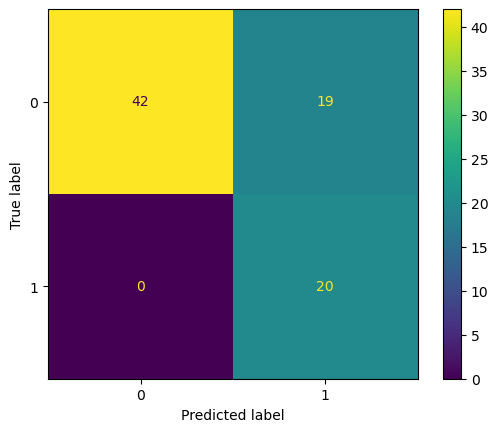

In [18]:
# The confusion matrix
labels = [0,1]
cm = confusion_matrix(y_test, y_pred_opti, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot();

## Select features by MI

In [20]:
# set X, y
X = df[['TDS_mg/L','WellDepth','SAR','Hardness_mg/L','Sulfate_mg/L','Chloride_mg/L','EC_SSURGO']]
y = df['label']

# feature scaling
scaler = MinMaxScaler((0,1))
X_scaled = scaler.fit_transform(X)

# split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# try default hyperparameters
model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [21]:
# accuracy score
accur = accuracy_score(y_pred, y_test)
print(accur)

0.8271604938271605


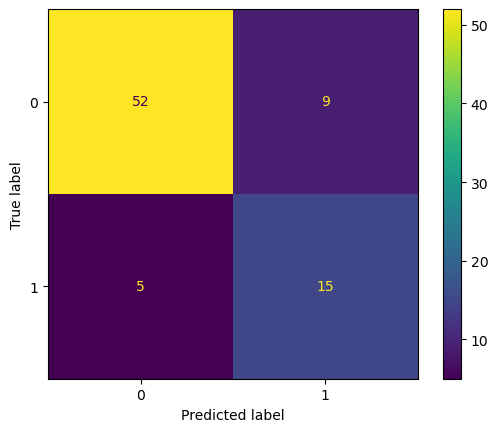

In [22]:
# The confusion matrix
labels = [0,1]
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot();

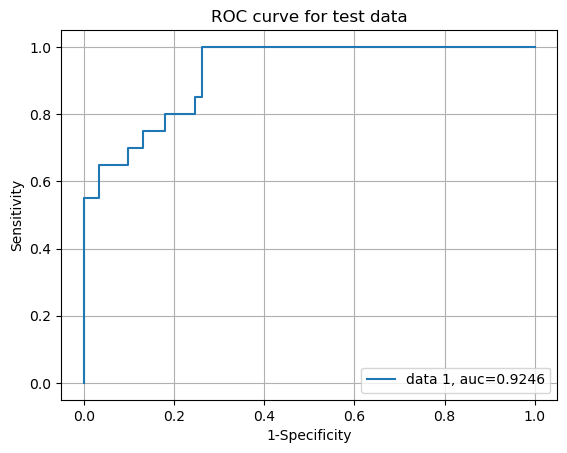

In [35]:
from sklearn import metrics
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(round(auc,4)))
plt.legend(loc=4)
plt.title('ROC curve for test data')
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.grid()
plt.show()

In [24]:
# define objective function
def objective(trial):
    # select hyperparameters to optimize 'priors': None, 'var_smoothing': 1e-10, 1e-3
    var_smoothing = trial.suggest_float("var_smoothing", 1e-15, 1)
    
    # build the model
    model = GaussianNB(var_smoothing=var_smoothing, priors=None)

    # train the model
    model.fit(X_train, y_train)

    # Evaluate how good it is on the test set, using accuracy
    y_pred = model.predict(X_test)
    accur = accuracy_score(y_pred, y_test)
    #f1 = f1_score(y_pred, y_test, average="weighted")

    return accur if accur != np.nan else float("inf")

# for convenience, print some optimization trials information
def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")


# optimize hyperparameters by maximize the accuracy on the test set
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1, callbacks=[print_callback])

[I 2023-03-10 20:02:59,188] A new study created in memory with name: no-name-7813419c-89a1-4925-a373-110914912186
[I 2023-03-10 20:02:59,193] Trial 0 finished with value: 0.8641975308641975 and parameters: {'var_smoothing': 0.6149281628009051}. Best is trial 0 with value: 0.8641975308641975.


Current value: 0.8641975308641975, Current params: {'var_smoothing': 0.6149281628009051}
Best value: 0.8641975308641975, Best params: {'var_smoothing': 0.6149281628009051}


In [25]:
model_opti = GaussianNB(var_smoothing=0.6149281628009051, priors=None)
model_opti.fit(X_train, y_train)
y_pred_opti = model_opti.predict(X_test)

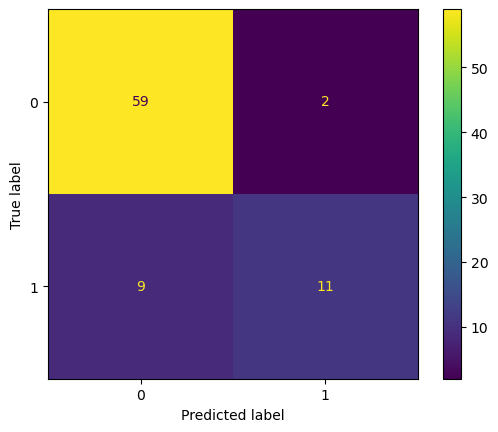

In [26]:
# The confusion matrix
labels = [0,1]
cm = confusion_matrix(y_test, y_pred_opti, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot();

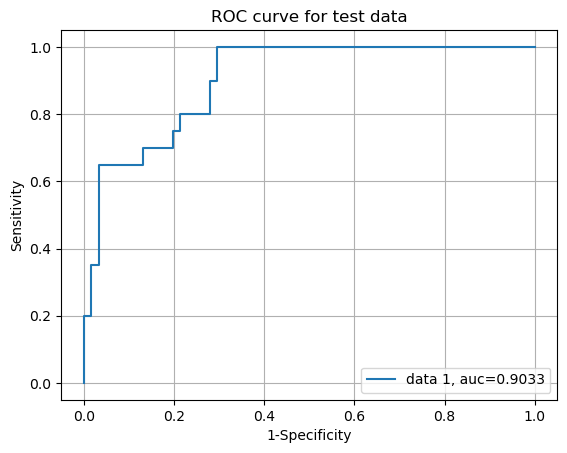

In [36]:
y_pred_proba = model_opti.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(round(auc,4)))
plt.legend(loc=4)
plt.title('ROC curve for test data')
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.grid()
plt.show()

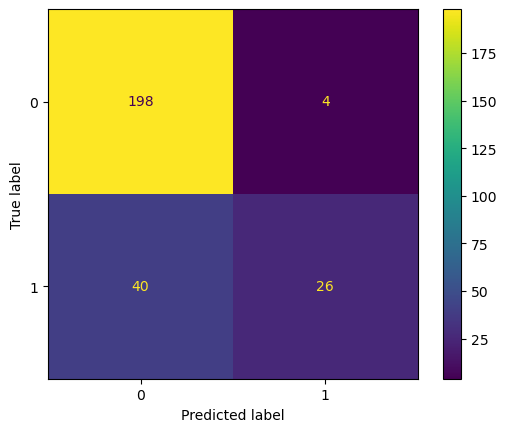

In [28]:
# use optimized model
df_pred = model_opti.predict(X_scaled)
# The confusion matrix
labels = [0,1]
cm = confusion_matrix(y, df_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot();

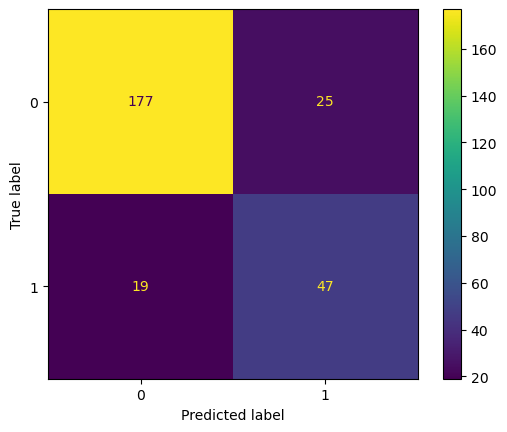

In [29]:
# use default model
df_pred = model.predict(X_scaled)
# The confusion matrix
labels = [0,1]
cm = confusion_matrix(y, df_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot();

The performance of default model on whole dataset is better than optimized model. So we ues default model to predict whole dataset and save predicted labels into the excel.

In [30]:
df_pred = pd.DataFrame(df_pred, columns = ['label_NBCpred'])
df_NBCpred = pd.concat([df, df_pred], axis=1)

In [31]:
df_NBCpred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268 entries, 0 to 267
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      268 non-null    int64  
 1   StateWellN      268 non-null    int64  
 2   StateWel_1      268 non-null    int64  
 3   LatitudeDD      268 non-null    float64
 4   Dlat            268 non-null    int64  
 5   Mlat            268 non-null    int64  
 6   Slat            268 non-null    float64
 7   LongitudeD      268 non-null    float64
 8   Dlong           268 non-null    int64  
 9   Mlong           268 non-null    int64  
 10  Slong           268 non-null    float64
 11  TDS_mg/L        268 non-null    float64
 12  WellDepth       268 non-null    int64  
 13  SAR             268 non-null    float64
 14  Hardness_mg/L   268 non-null    float64
 15  Calcium_mg/L    268 non-null    float64
 16  Magnesium_mg/L  268 non-null    float64
 17  Sulfate_mg/L    268 non-null    flo

In [32]:
df_NBCpred.to_excel('C:/Users/mengj/OneDrive - lamar.edu/LectureNote2023/MLforCivilEng/TeamProject2/WoodbineData_NBCpred.xlsx')